In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import NormalDistPredictor
from models.conv_rnn_model import BaseLSTMModel, RNNRouter

# from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.PPO_RNN import PPORNNDiscrete
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callbacks import versatile_callback

In [26]:
actor_lr = 1e-4
critic_lr = 1e-3

hidden_size = 64

discount = 0.99

clip_ratio = 0.2

# discount = 0.9

# clip_ratio = 0.05

# ppo_steps = 8
ppo_steps = 8

num_envs = 64

iters = 200

# num_envs = 16

# iters = 5000

max_episode_steps = 1000

env_name = "Breakout-MinAtar"

In [6]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape
action_num = env.action_space(env_params).n
action_size = 1

In [27]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

start_lr, end_lr = 5e-5, 1e-6
steps = ppo_steps * iters
lr_scheduler = optax.linear_schedule(
  init_value=start_lr,
  end_value=end_lr,
  transition_steps=steps,
)

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(43)
    
    obs_dummy = jnp.ones([1, 1, *obs_size])
    done_dummy = jnp.ones([1, 1, 1])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 2, num_early_layers = 1), RNNRouter(nn.Dense(features = action_num))])
    actor_params = actor_model.init(actor_init_key, obs_dummy, done_dummy)['params']
    actor_tx = optax.chain(
       optax.clip_by_global_norm(0.5),
       # optax.clip(1e-6),
       optax.adamw(actor_lr, 0.99, 0.99),
       # optax.clip_by_global_norm(0.5),
       # optax.sgd(lr_scheduler),
    )
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 2, num_early_layers = 1), RNNRouter(nn.Dense(features = 1))])
    critic_params = critic_model.init(critic_init_key, obs_dummy, done_dummy)['params']
    critic_tx = optax.chain(
       optax.clip_by_global_norm(0.5),
       # optax.clip(1e-6),
       optax.adamw(critic_lr, 0.99, 0.99),
       # optax.clip_by_global_norm(0.5),
       # optax.sgd(lr_scheduler),
    )
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )

    # def entropy_scheduler():
        
    
    agent = PPORNNDiscrete(gae_estimator(discount, 0.95), clip_ratio, ppo_steps, target_kl = 1e-2, entropy_coef = 0.01)
    
    callback = versatile_callback(iters, tqdm_keys = ["episode_reward"])

    rnn_carry_initializer = lambda k: nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(k, (num_envs, hidden_size))

    fori_body = build_trainer(agent, env, env_params, num_envs, obs_size, action_size, max_episode_steps, callback, use_rnn_agent = True, rnn_carry_initializer = rnn_carry_initializer)
    
    carry = (actor, critic, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 200/200 [11:41<00:00,  3.39s/it, episode_reward=5.6192513] 

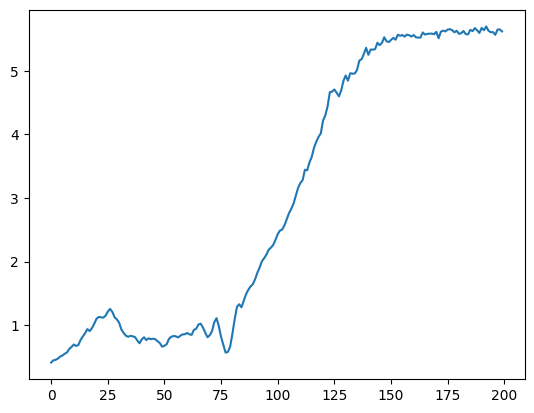

In [30]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(callback.history["episode_reward"])
plt.show()

In [31]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm

import numpy as np

actor = carry[0]

# gym_env = gym.make("'MinAtar/Breakout-v0", render_mode="rgb_array")

key = jax.random.PRNGKey(0)

c = nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(key, (1, hidden_size))
done = jnp.ones((1, 1, 1))

obs, env_state = env.reset(key, env_params)
frames = []
for t in tqdm(range(500)):
    key = jax.random.split(key)[0]
    
    frames.append(obs)
    c, action = agent.suggest_action(jnp.expand_dims(obs, (0, 1)), c, jnp.reshape(done, (1, 1)), actor)
    action = action.item()
    
    obs, env_state, reward, done, _ = env.step(key, env_state, action, env_params)
    if done:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
vis_frames = []

for ii, obs in enumerate(frames):
    color1 = jnp.array([0.01, 0.01, 0.01])
    color2 = jnp.array([1, 0, 0])
    color3 = jnp.array([0, 1, 0]) 
    color4 = jnp.array([0, 0, 1]) 
    color0 = jnp.array([1, 1, 1])
            
    color1 = jnp.expand_dims(color1, axis = (0, 1))
    color2 = jnp.expand_dims(color2, axis = (0, 1))
    color3 = jnp.expand_dims(color3, axis = (0, 1))
    color4 = jnp.expand_dims(color4, axis = (0, 1))
    color0 = jnp.expand_dims(color0, axis = (0, 1))
    
    vis = jnp.where(obs[:, :, [0]] == 1, color1, color0)
    # vis = jnp.where(obs[:, :, [1]] == 1, color2, vis)
    # vis = jnp.where(obs[:, :, [2]] == 1, color3, vis)
    vis = jnp.where(obs[:, :, [3]] == 1, color4, vis)

    vis = jnp.where(obs[:, :, [1]] == 1, color2, vis)
    vis = jnp.where(obs[:, :, [2]] == 1, color3, vis)

    vis_frames.append(vis)

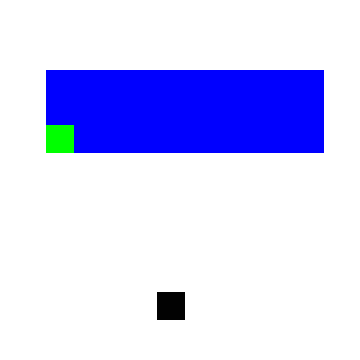

In [45]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    plt.ioff()
    
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 2.0, frames[0].shape[0] / 2.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=5)

save_frames_as_gif(vis_frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())